## Hyperspectral image classification: Analysis of different supervised methods

## What Are Hyperspectral Images?  

**Hyperspectral images** are a special type of images that capture detailed information about the **electromagnetic spectrum** of light reflected or emitted by an object or scene. Unlike regular images, which consist of three color channels (red, green, and blue - RGB), hyperspectral images record dozens or even hundreds of very narrow spectral bands, covering a broader range of wavelengths, from ultraviolet to infrared.  

Each material has a unique spectral signature, which can be used as a "fingerprint" for its identification. Therefore, hyperspectral images have a wide range of applications in **remote sensing**, thanks to their ability to recognize material components from a distance, without labels, and in a non-destructive way. Hyperspectral imaging is used in various fields such as **astronomy, agriculture, molecular biology, biomedical imaging, mineralogy, geology, physics, cultural heritage, food processing, environmental studies**, and **surveillance**.

![img](./images/1.png "Title")

### Dataset Used  

For this project, I used the [Salinas](https://www.ehu.eus/ccwintco/index.php/Hyperspectral_Remote_Sensing_Scenes#Botswana) dataset, which represents a scene captured by the AVIRIS sensor in 224 spectral bands with a spatial resolution of 3.7 meters. The dataset contains 217x512 pixels, and each pixel is labeled with one of the 16 land cover classes.  


In [1]:
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load hyperspectral image data
X_3d = loadmat('./datasets/salinas/salinas.mat')['salinas']
y_3d = loadmat('./datasets/salinas/salinas_gt.mat')['salinas_gt']
n, m = y_3d.shape

print(f"X shape: {X_3d.shape}, {X_3d.dtype}")
print(f"y shape: {y_3d.shape}, {y_3d.dtype}")

X shape: (512, 217, 224), int16
y shape: (512, 217), uint8


### The 16 land cover classes are:

0. Unlabelled
1. Brocoli_green_weeds_1
2. Brocoli_green_weeds_2
3. Fallow
4. Fallow_rough_plow
5. Fallow_smooth
6. Stubble
7. Celery
8. Grapes_untrained
9. Soil_vinyard_develop
10. Corn_senesced_green_weeds
11. Lettuce_romaine_4wk
12. Lettuce_romaine_5wk
13. Lettuce_romaine_6wk
14. Lettuce_romaine_7wk
15. Vinyard_untrained
16. Vinyard_vertical_trellis

In [3]:
num_classes = len(np.unique(y_3d))
print(f"Number of classes: {num_classes}")
print(f"Class labels: {np.unique(y_3d)}")

Number of classes: 17
Class labels: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]


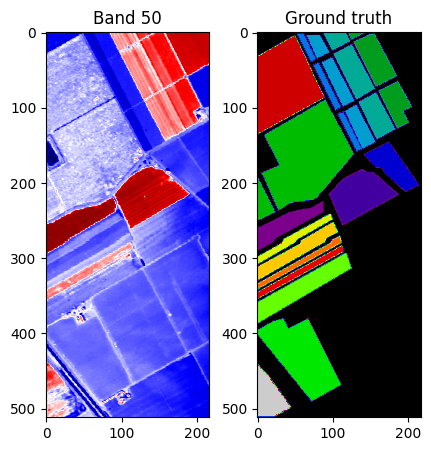

In [4]:
# plot a band from X and the ground truth y
fig, ax = plt.subplots(1, 2, figsize=(5, 5))
ax[0].imshow(X_3d[:, :, 50], cmap='seismic')
ax[0].set_title('Band 50')
ax[1].imshow(y_3d, cmap='nipy_spectral')
ax[1].set_title('Ground truth')
plt.show()



## Dimensionality Reduction of the Dataset  

First, the data needs to be normalized to apply various dimensionality reduction methods. The data is normalized to fall within the range [0, 1] using `MinMaxScaler` from `sklearn.preprocessing`.  

In [5]:
from sklearn.preprocessing import MinMaxScaler

# reshape X to 2D
X = X_3d.reshape(-1, X_3d.shape[2])
y = y_3d.flatten()

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

scaler = MinMaxScaler()
X = scaler.fit_transform(X)

X shape: (111104, 224)
y shape: (111104,)


We test different dimensionality reduction methods, such as `PCA`(Principal Component Analysis), `NMF`(Nonegative Matrix Factorization), and `ICA`(Independent Component Analysis), to determine which method is best suited for the given dataset. To validate the most suitable method, we analyze how much information is retained by each method, as well as the reconstruction error of the data, using **10 components**.  

In [6]:
from sklearn.decomposition import PCA, NMF, FastICA

methods = [PCA, NMF, FastICA]
n_components = 10

# apply dimensionality reduction
for method in methods:
    dr = method(n_components=n_components, random_state=0)
    X_dr = dr.fit_transform(X)
    
    print(f'{method.__name__}:', end=' ')
    
    #calculate the explained variance
    try:
        explained_variance = np.sum(dr.explained_variance_ratio_)
        print(f'Explained variance: {explained_variance:.2f}', end=', ')
    except AttributeError:
        pass
    
    #calculate the reconstruction error
    X_reconstructed = dr.inverse_transform(X_dr)
    error = np.mean((X - X_reconstructed) ** 2)
    print(f'Reconstruction error: {error:.2e}')

PCA: Explained variance: 1.00, Reconstruction error: 1.34e-05


C:\Users\User\AppData\Roaming\Python\Python312\site-packages\sklearn\decomposition\_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


NMF: Reconstruction error: 2.51e-05
FastICA: Reconstruction error: 1.34e-05


We observe that using `PCA`, we retain all the information, and the reconstruction error is the lowest, along with `ICA`. An advantage of the `PCA` method is that it is fast and easy to understand:  

$$X = U \Sigma V^T$$  

The matrix $X$ is reconstructed using only the first 10 principal components:  

$$X_{pca} = U[:, :10] \Sigma[:10, :10] V[:, :10]^T$$  

For this dataset, `NMF` is not a suitable method because it is very slow, and the reconstruction error is the highest.  


PCA components shape: (111104, 10)
PCA explained variance: 1.00


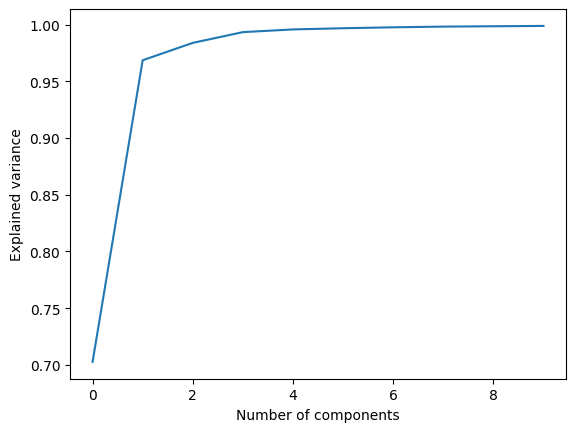

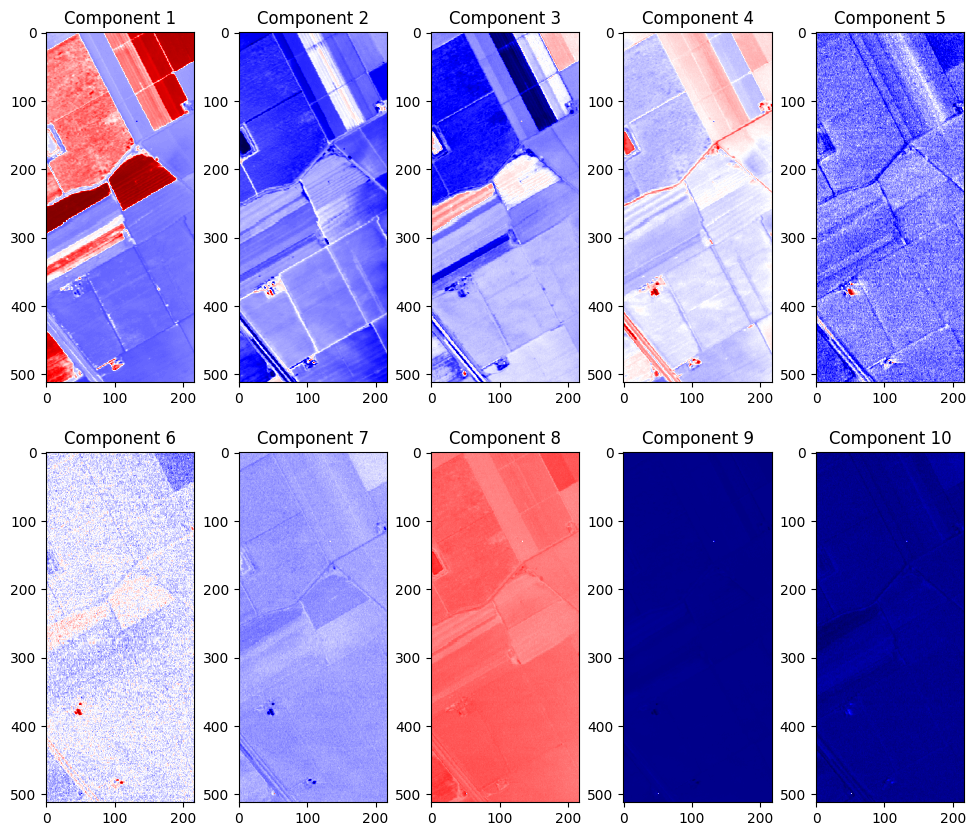

In [7]:
from sklearn.decomposition import PCA

pca = PCA(n_components=10, random_state=0)
X_pca = pca.fit_transform(X)

print(f'PCA components shape: {X_pca.shape}')

print(f'PCA explained variance: {np.sum(pca.explained_variance_ratio_):.2f}')

# plot the explained variance
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Explained variance')
plt.show()

# plot each PCA component
plt.figure(figsize=(12, 10))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X_pca[:, i].reshape(n, m), cmap='seismic')
    plt.title(f'Component {i + 1}')
plt.show()


### Splitting the Dataset into Training and Testing Sets

In [8]:
from sklearn.model_selection import train_test_split

# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=0)

print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (88883, 10)
X_test shape: (22221, 10)
y_train shape: (88883,)
y_test shape: (22221,)


## Data Classification  

For data classification, we will use different classification methods such as `Logistic Regression` and `Support Vector Machine (SVM)`:  

### 1. Logistic Regression  

Logistic regression is a supervised learning algorithm used for data classification. It is a binary classification algorithm that can be extended to classify data into multiple classes, such as binary classification, multi-class classification, and one-vs-all classification. Instead of linear regression, which produces continuous values, logistic regression outputs probabilities, making it useful for classification problems.  

$$z = \theta_0 + \theta_1 x_1 + ... + \theta_n x_n = \theta^T x$$  

To calculate the probability of belonging to a class, the sigmoid function is used:  

$$\hat{y} = \sigma(z) = \frac{1}{1 + e^{-z}}$$  

To train the model, the cost function is used to find the parameters $\theta$ that minimize classification error:  

$$L(y_i, \hat{y}_i) = - \left[ y_i \log(\hat{y}_i) + (1 - y_i) \log(1 - \hat{y}_i) \right]$$  

To find the parameters $\theta$, stochastic gradient descent (SGD) is used:  

$$\theta_{k+1} = \theta_k - \alpha \frac{\partial L}{\partial \theta_k}$$  

where $\alpha$ is the optimization step, also called the *learning rate*.  

**> Advantages:** It is a simple, fast, and efficient algorithm for classifying linearly separable data. It is less prone to overfitting when regularization (e.g., L2) is applied and when working with small or medium-sized datasets.  

**> Disadvantages:** It is inefficient for non-linearly separable data as it cannot capture complex relationships between features. It is also sensitive to input data that may contain noise or missing values (outliers).  

### 2. Support Vector Machine (SVM)  

Support Vector Machine (SVM) is a classification algorithm that seeks to find a hyperplane (with maximum margin) that separates two classes. This algorithm is used for classifying both linearly and non-linearly separable data and is efficient in high-dimensional spaces.  

Thus, the SVM optimization problem is to find the hyperplane that maximizes the margin between the two classes:  

$$\min_{w \in \mathbb{R}^n, b \in \mathbb{R}} \frac{1}{2} \|w\|^2 + C \sum_{i=1}^{N} \zeta_i$$  

s.t.  

$$y_i(w^T x_i + b) \geq 1 - \zeta_i, \forall i = 1, ..., N$$  

where $w$ is the weight vector, $b$ is the bias, $C$ is a regularization hyperparameter that represents the trade-off between choosing a maximum-margin hyperplane and minimizing classification errors, and $\zeta_i$ is the slack variable that measures how much a point is misclassified.  

For data that is not linearly separable, a **kernel** is used to transform the data into a higher-dimensional space where they become linearly separable. A *kernel* is a function that maps the data into a higher-dimensional space. A common *kernel* used is the **Radial Basis Function (RBF) kernel**:  

$$K(x, x') = \exp\left(-\frac{\|x - x'\|^2}{2 \sigma^2}\right)$$  

where $\sigma$ is a hyperparameter that controls the extent of the hyperplane, and $\|x - x'\|^2$ is the Euclidean distance between $x$ and $x'$.  

By substituting $\gamma = \frac{1}{2 \sigma^2}$, we obtain the formulation implemented in `sklearn`:  

$$K(x, x') = \exp(-\gamma \|x - x'\|^2)$$  

**> Advantages:** SVM aims to find the **maximum margin** between classes, which helps improve generalization. Theoretically, this reduces the risk of overfitting. It is efficient for non-linear data since it can use different types of kernels to transform data into a higher-dimensional space, making SVM a powerful algorithm for complex data classification.  

**> Disadvantages:** SVM is sensitive to the choice of hyperparameters, such as the regularization cost $C$ and the RBF kernel parameter $\gamma$. It is also sensitive to data scaling since it calculates distances between points. Additionally, SVM is inefficient for large datasets, as training time increases exponentially with dataset size.  

### 3. Random Forest  

Random Forest is an ensemble-based classification and regression algorithm that consists of multiple decision trees. Each decision tree is trained on a random subset of the data and features. For classification, Random Forest uses majority voting from decision trees, while for regression, it uses the average prediction of all trees.  

A decision tree makes sequential decisions based on a set of features. At each node, the best feature is selected using a "split quality" function. This process is repeated recursively until a certain tree depth is reached or no training data remains.  

Common split quality criteria include `gini impurity` and `entropy`:  

$$Gini = 1 - \sum_{i=1}^{n} p_i^2$$  
$$Entropy = - \sum_{i=1}^{n} p_i \log(p_i)$$  

Another important element in Random Forest is the random selection of features. Instead of using all features, only a random subset of $m$ features out of the $d$ available is chosen at each node. This reduces correlation between trees and results in a more robust model.  

For classification, the final result is determined through majority voting. If there are $K$ trees in the ensemble, and for a given example, the $k$-th tree predicts class $c_k$, then the final class $\hat{y}$ is:  

$$\hat{y} = \arg\max_{c} \sum_{k=1}^{K} \mathbb{I}(c_k = c)$$  

where $\mathbb{I}$ is an indicator function that is 1 if $c_k = c$, and 0 otherwise.  

**> Advantages:** Random Forest is a powerful and robust algorithm for data classification. It is efficient during training and can handle missing data and outliers. Additionally, Random Forest is effective in identifying important features, as it can compute feature importance. Majority voting among multiple trees leads to better generalization, preventing overfitting.  

**> Disadvantages:** Random Forest can still be prone to overfitting if it becomes too complex. Since it consists of multiple trees, model interpretation is difficult compared to Logistic Regression or a single decision tree. It can also consume significant memory, especially with very large datasets.  

### 4. Neural Networks - Fully Connected/Dense Neural Network  

Neural networks are computational models inspired by the human brain that identify complex patterns in data. They consist of nodes (neurons) organized in layers: an input layer, one or more hidden layers, and an output layer. Each neuron receives an input, processes it using an activation function, and passes the signal forward. A fully connected neural network (Dense Neural Network) is a model where each neuron in a layer is connected to every neuron in the next layer.  

Let $ l $ be a hidden layer. Each neuron in this layer computes a linear combination of inputs from the previous layer:  

$$
\mathbf{z}^{(l)} = \mathbf{W}^{(l)} \mathbf{x}^{(l-1)} + \mathbf{b}^{(l)}
$$  

where:  
- $ \mathbf{W}^{(l)} \in \mathbb{R}^{m_l \times m_{l-1}} $ is the weight matrix for layer $ l $, with $ m_{l-1} $ and $ m_l $ being the sizes of the previous and current layer;  
- $ \mathbf{b}^{(l)} \in \mathbb{R}^{m_l} $ is the bias vector for layer $ l $;  
- $ \mathbf{x}^{(l-1)} $ is the output of the previous layer (input for the current layer).  

Examples of activation functions:  
- **ReLU**: $ \text{ReLU}(x) = \max(0, x) $  
- **Sigmoid**: $ \sigma(x) = \frac{1}{1 + e^{-x}} $  
- **Tanh**: $ \tanh(x) = \frac{e^x - e^{-x}}{e^x + e^{-x}} $  

**> Advantages:** Neural networks can learn complex relationships and hierarchical data representations. They are robust to missing data and noise.  

**> Disadvantages:** High computational cost, sensitivity to architecture, and risk of overfitting.  


### Implementation of classification methods using `sklearn` and `PyTorch` for neural networks


### 1. Logistic Regression

C:\Users\User\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\User\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\User\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

              precision    recall  f1-score   support

           0       0.75      0.90      0.82     11438
           1       0.85      0.96      0.90       422
           2       0.83      0.92      0.87       733
           3       0.00      0.00      0.00       416
           4       0.75      0.65      0.70       291
           5       0.44      0.08      0.14       539
           6       0.88      0.97      0.92       757
           7       0.89      0.99      0.93       712
           8       0.67      0.88      0.76      2219
           9       0.43      0.11      0.18      1237
          10       0.68      0.48      0.57       644
          11       0.00      0.00      0.00       219
          12       0.00      0.00      0.00       376
          13       0.00      0.00      0.00       187
          14       0.63      0.24      0.35       213
          15       0.64      0.44      0.53      1423
          16       0.91      0.81      0.86       395

    accuracy              

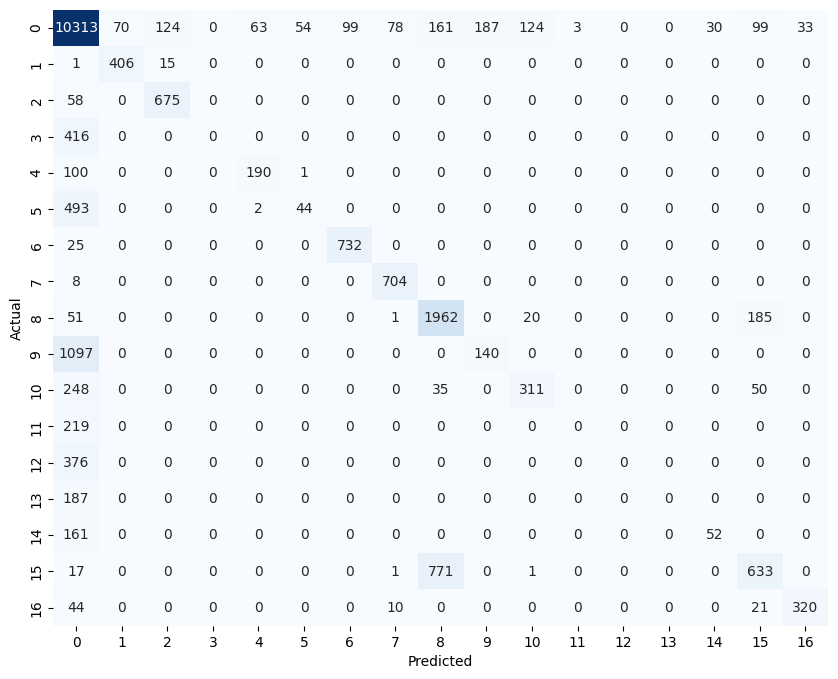

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# train a logistic regression model
clf = LogisticRegression(random_state=0, max_iter=1000)
clf.fit(X_train, y_train)

# make predictions
y_pred = clf.predict(X_test)

# print the classification report
print(classification_report(y_test, y_pred))

print(f'Accuracy: {clf.score(X_test, y_test):.2f}')

# plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap='Blues', cbar=False, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### 2. Support Vector Machine (SVM)

              precision    recall  f1-score   support

           0       0.95      0.91      0.93     11438
           1       0.84      1.00      0.91       422
           2       0.91      0.98      0.94       733
           3       0.80      0.80      0.80       416
           4       0.88      0.85      0.86       291
           5       0.82      0.96      0.89       539
           6       0.91      0.98      0.94       757
           7       0.92      0.99      0.95       712
           8       0.77      0.87      0.82      2219
           9       0.93      0.94      0.93      1237
          10       0.90      0.87      0.88       644
          11       0.86      0.80      0.83       219
          12       0.86      0.99      0.92       376
          13       0.83      0.87      0.85       187
          14       0.75      0.87      0.81       213
          15       0.78      0.65      0.71      1423
          16       0.90      0.96      0.93       395

    accuracy              

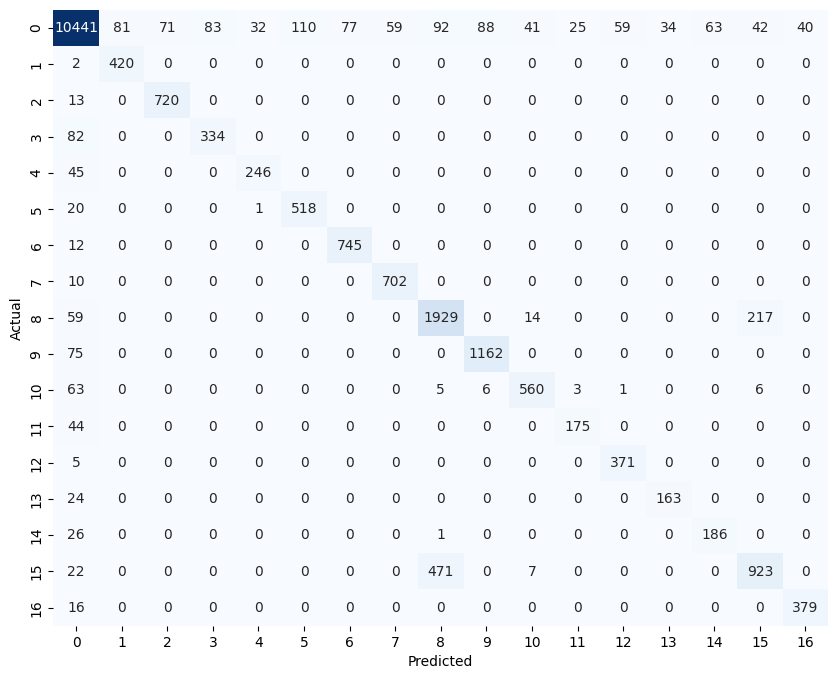

In [10]:
from sklearn.svm import SVC

# train a support vector machine model
clf = SVC(random_state=0, kernel='rbf', C=100)
clf.fit(X_train, y_train) 

# make predictions
y_pred = clf.predict(X_test)

# print the classification report
print(classification_report(y_test, y_pred))
print(f'Accuracy: {clf.score(X_test, y_test):.2f}')

# plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap='Blues', cbar=False, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


### 3. Random Forest Classifier (RFC)

              precision    recall  f1-score   support

           0       0.95      0.94      0.95     11438
           1       0.89      0.97      0.93       422
           2       0.94      0.98      0.96       733
           3       0.91      0.86      0.89       416
           4       0.92      0.87      0.90       291
           5       0.91      0.94      0.92       539
           6       0.93      0.96      0.94       757
           7       0.94      0.97      0.95       712
           8       0.84      0.89      0.86      2219
           9       0.95      0.94      0.94      1237
          10       0.94      0.90      0.92       644
          11       0.88      0.82      0.85       219
          12       0.92      0.95      0.93       376
          13       0.88      0.88      0.88       187
          14       0.88      0.90      0.89       213
          15       0.83      0.76      0.80      1423
          16       0.93      0.96      0.94       395

    accuracy              

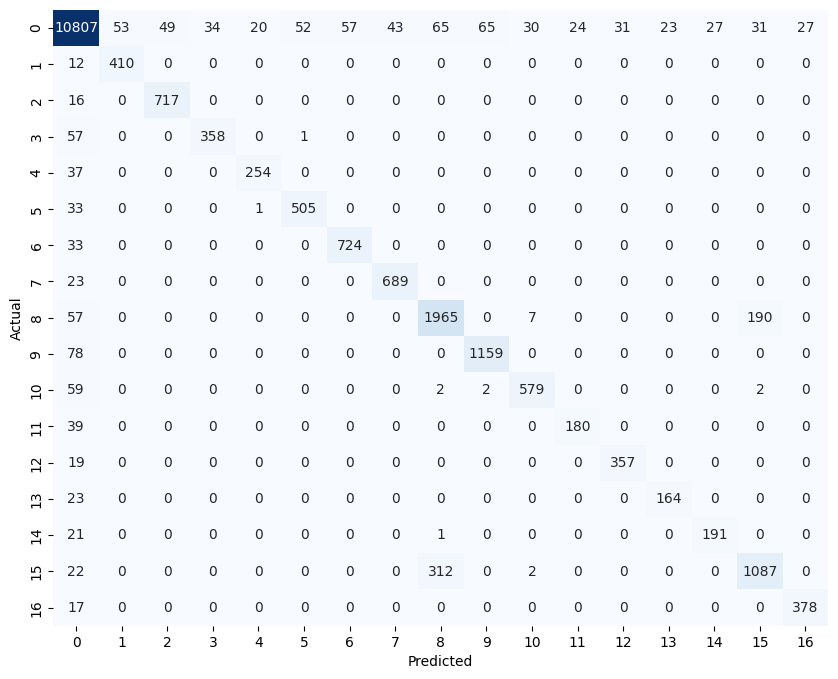

In [11]:
from sklearn.ensemble import RandomForestClassifier

# train a random forest model
clf = RandomForestClassifier(random_state=0)
clf.fit(X_train, y_train)

# make predictions
y_pred = clf.predict(X_test)

# print the classification report
print(classification_report(y_test, y_pred))
print(f'Accuracy: {clf.score(X_test, y_test):.2f}')

# plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap='Blues', cbar=False, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## 4. Neural Networks - Fully Connected/Dense Neural Network

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchsummary import summary

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

We use the data reduced with PCA to reduce the training time of the neural network, as this data contains all the necessary information for classification.

We split the dataset into training, validation, and test sets, with a proportion of 60%, 20%, and 20%.


In [13]:
# split data from X_pca in train, validation and test
X_train, X_val, y_train, y_val = train_test_split(X_pca, y, test_size=0.4, random_state=0)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=0)

print(f'X_train shape: {X_train.shape}')
print(f'X_val shape: {X_val.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_train shape: {y_train.shape}')


X_train shape: (66662, 10)
X_val shape: (22221, 10)
X_test shape: (22221, 10)
y_train shape: (66662,)


The `HyperspectralDataset` class is used to load the data and transform it into tensors to be used in the neural network. The datasets are converted into Dataloaders to load the data in iterable batches.


In [14]:
class HyperspectralDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
train_set = HyperspectralDataset(X_train, y_train)
val_set = HyperspectralDataset(X_val, y_val)
test_set = HyperspectralDataset(X_test, y_test)

batch_size = 32
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

In [93]:
image, label = next(iter(train_loader))
print(f'Image shape: {image.shape}, Label shape: {label.shape}')

Image shape: torch.Size([32, 10]), Label shape: torch.Size([32])


We define the architecture of the neural network, with an input layer, 2 hidden layers, and an output layer. We use the `ReLU` activation function for the hidden layers and `LogSoftmax` for the output layer (included in the `CrossEntropyLoss` loss function).


In [15]:
# build fully connected neural network
class FCN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(FCN, self).__init__()
        self.fc1 = nn.Linear(input_size, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, num_classes)
        
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        
        x = self.fc2(x)
        x = self.relu(x)
        
        x = self.fc3(x)
        x = self.relu(x)
        
        x = self.fc4(x)
        return x
    

We define hyperparameters such as the learning rate, the number of epochs, instantiate the model on the GPU (if available), and define the loss function and optimizer.

The loss function is `CrossEntropyLoss`, which is used for multi-class classification. The optimizer is `Adam`, which is an optimization algorithm based on adaptive gradients.


In [19]:
learning_rate = 1e-3
epochs = 20
num_classes = len(np.unique(y_train))

model = FCN(input_size=X_train.shape[1], num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

summary(model, input_size=(X_train.shape[1],))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 512]           5,632
              ReLU-2                  [-1, 512]               0
            Linear-3                  [-1, 256]         131,328
              ReLU-4                  [-1, 256]               0
            Linear-5                  [-1, 128]          32,896
              ReLU-6                  [-1, 128]               0
            Linear-7                   [-1, 17]           2,193
Total params: 172,049
Trainable params: 172,049
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.66
Estimated Total Size (MB): 0.67
----------------------------------------------------------------


During the training stage, in each epoch, for each batch of data, the model's predictions are calculated, the loss is computed, and backpropagation is performed to update the model's parameters. At the end of each epoch, the model's accuracy on the validation set is calculated, and the model is saved if the validation loss is minimal.


EPOCH 1: Train loss: 0.5538, Train accuracy: 0.7898 Valid loss: 0.3997, Valid accuracy: 0.8484
Model saved
EPOCH 2: Train loss: 0.3611, Train accuracy: 0.8632 Valid loss: 0.3379, Valid accuracy: 0.8700
Model saved
EPOCH 3: Train loss: 0.3172, Train accuracy: 0.8784 Valid loss: 0.3285, Valid accuracy: 0.8730
Model saved
EPOCH 4: Train loss: 0.2931, Train accuracy: 0.8874 Valid loss: 0.2947, Valid accuracy: 0.8883
Model saved
EPOCH 5: Train loss: 0.2779, Train accuracy: 0.8926 Valid loss: 0.2675, Valid accuracy: 0.8988
Model saved
EPOCH 6: Train loss: 0.2656, Train accuracy: 0.8973 Valid loss: 0.2597, Valid accuracy: 0.8994
Model saved
EPOCH 7: Train loss: 0.2549, Train accuracy: 0.9005 Valid loss: 0.2480, Valid accuracy: 0.9055
Model saved
EPOCH 8: Train loss: 0.2466, Train accuracy: 0.9045 Valid loss: 0.2409, Valid accuracy: 0.9069
Model saved
EPOCH 9: Train loss: 0.2390, Train accuracy: 0.9063 Valid loss: 0.2383, Valid accuracy: 0.9062
Model saved
EPOCH 10: Train loss: 0.2329, Train a

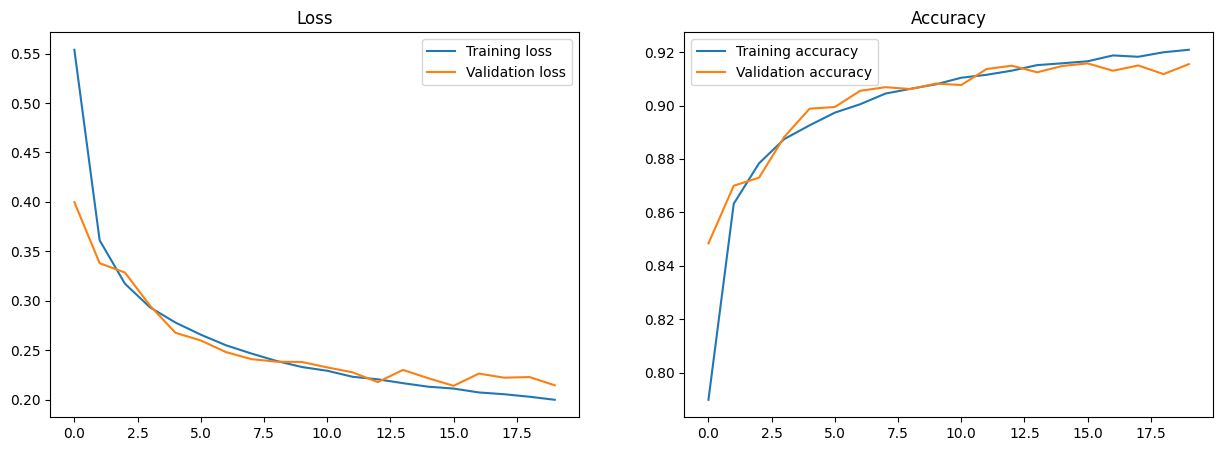

In [20]:
def train(model, train_loader, valid_loader, epochs, criterion, optimizer, device):
    best_valid_loss = np.Inf
    # store losses and accuracies for plotting
    train_losses, valid_losses = [], []
    train_accuracies, valid_accuracies = [], []

    for epoch in range(epochs):
        train_loss = 0
        valid_loss = 0
        train_accuracy = 0
        valid_accuracy = 0
        
        print(f"EPOCH {epoch+1}: ", end='')
        
        
        model.train()
        for image, label in train_loader:
            # get current batch
            label = label.type(torch.LongTensor)
            image, label = image.to(device), label.to(device)
            
            # set gradients to zero
            optimizer.zero_grad()
            
            # forward pass
            output = model(image)
            # calculate loss
            loss = criterion(output, label)
            # perform backpropagation
            loss.backward()
            # update weights
            optimizer.step()
            
            # calculate training loss and accuracy
            train_loss += loss.item()
            train_accuracy += (output.argmax(dim=1) == label).float().mean()
            
        print(f"Train loss: {train_loss/len(train_loader):.4f}, Train accuracy: {train_accuracy/len(train_loader):.4f}", end=' ')
        
        # validate the model
        with torch.no_grad():
            # set model to evaluation mode
            model.eval()
            for image, label in valid_loader:
                # get current batch
                label = label.type(torch.LongTensor)
                image, label = image.to(device), label.to(device)
                    
                # only forward pass
                output = model(image)
                # calculate loss
                loss = criterion(output, label)
                
                # calculate validation loss and accuracy
                valid_loss += loss.item()
                valid_accuracy += (output.argmax(dim=1) == label).float().mean()
            
        print(f"Valid loss: {valid_loss/len(valid_loader):.4f}, Valid accuracy: {valid_accuracy/len(valid_loader):.4f}")
        
        # if loss is minimized, save the model
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), 'best_model.pth')
            print('Model saved')
            
        # append losses and accuracies for plotting
        train_losses.append(train_loss/len(train_loader))
        valid_losses.append(valid_loss/len(valid_loader))
        train_accuracies.append(train_accuracy/len(train_loader))
        valid_accuracies.append(valid_accuracy/len(valid_loader))

        
    return train_losses, valid_losses, train_accuracies, valid_accuracies
    
train_losses, valid_losses, train_accuracies, valid_accuracies = train(model, train_loader, val_loader, epochs, criterion, optimizer, device)

# convert lists to numpy arrays
train_losses = np.array(train_losses)
valid_losses = np.array(valid_losses)
train_accuracies = [x.cpu().detach().numpy() for x in train_accuracies]
valid_accuracies = [x.cpu().detach().numpy() for x in valid_accuracies]


#plot losses
ax, fig = plt.subplots(1, 2, figsize=(15, 5))
fig[0].plot(train_losses, label='Training loss')
fig[0].plot(valid_losses, label='Validation loss')
fig[0].set_title('Loss')
fig[0].legend()

fig[1].plot(train_accuracies, label='Training accuracy')
fig[1].plot(valid_accuracies, label='Validation accuracy')
fig[1].set_title('Accuracy')
fig[1].legend()

plt.show()

Test accuracy: 0.9166
              precision    recall  f1-score   support

           0       0.97      0.93      0.95     11396
           1       0.85      0.98      0.91       411
           2       0.92      0.98      0.95       747
           3       0.86      0.94      0.90       372
           4       0.94      0.85      0.89       287
           5       0.87      0.95      0.91       549
           6       0.93      0.96      0.95       779
           7       0.93      0.99      0.95       727
           8       0.84      0.84      0.84      2267
           9       0.96      0.94      0.95      1209
          10       0.92      0.93      0.92       683
          11       0.84      0.93      0.88       208
          12       0.84      0.99      0.91       350
          13       0.84      0.89      0.86       186
          14       0.87      0.94      0.91       221
          15       0.74      0.77      0.75      1448
          16       0.91      0.98      0.94       381

    

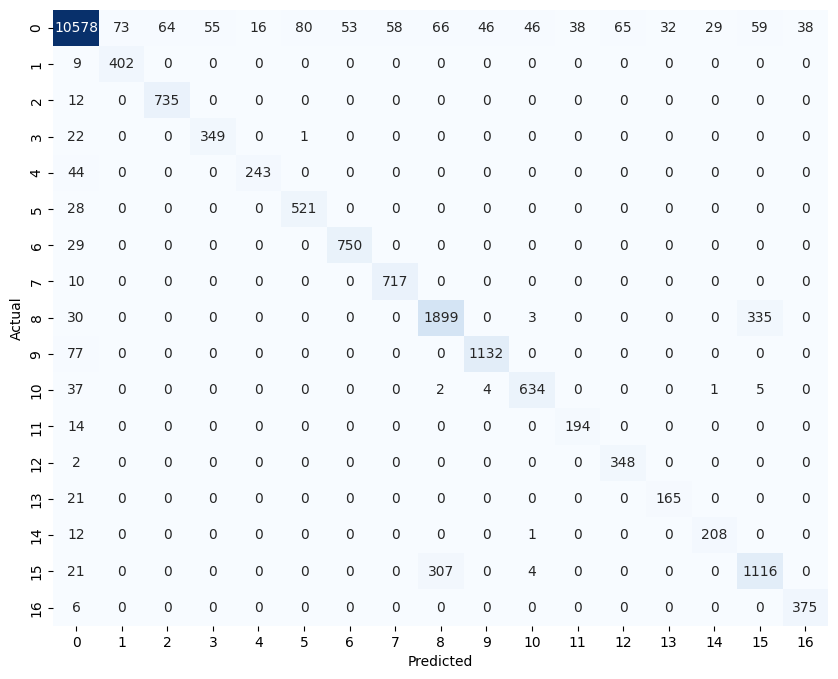

In [21]:
from sklearn.metrics import classification_report, confusion_matrix
# load the best model
path = "./best_model.pth"

# instantiate the model and set it to evaluation mode
model = FCN(input_size=X_train.shape[1], num_classes=num_classes).to(device)
model.load_state_dict(torch.load(path, weights_only=True))
model.eval()

# test the model
with torch.no_grad():
    test_accuracy = 0
    for image, label in test_loader:
        # get current batch
        label = label.type(torch.LongTensor)
        image, label = image.to(device), label.to(device)
        
        # only forward pass
        output = model(image)
        
        # calculate test accuracy
        test_accuracy += (output.argmax(dim=1) == label).float().mean()
        
    print(f'Test accuracy: {test_accuracy/len(test_loader):.4f}')
    
    # calculate classification report and confusion matrix
    y_pred = []
    y_true = []
    
    for image, label in test_loader:
        label = label.type(torch.LongTensor)
        image, label = image.to(device), label.to(device)
        
        output = model(image)
        y_pred.extend(output.argmax(dim=1).cpu().numpy())
        y_true.extend(label.cpu().numpy())
        
    print(classification_report(y_true, y_pred))
    # plot the confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, cmap='Blues', cbar=False, fmt='d')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

### Conclusions

For hyperspectral data, the `PCA` method is the most suitable for dimensionality reduction, as it retains all the information and has the lowest reconstruction error. Regarding classification methods, `Neural Networks` are the most suitable for hyperspectral image classification because they can learn complex relationships in the data and adapt well to nonlinear datasets, achieving an accuracy of **92%**. With the same **92%** accuracy, the `Random Forest` method is suitable for hyperspectral image classification as it can handle outliers and is robust to overfitting. Close to this method is `SVM`, with an accuracy of **90%**, but with a much higher training time compared to `Random Forest`. `Logistic Regression` is the least suitable method for hyperspectral image classification, with an accuracy of **74%**, a result expected given the nonlinearity of the data.

For the Neural Network used, the training time is relatively low, but almost identical to that of the `SVM` method. This is due to the fact that the data was reduced using `PCA`, and the training was done on a GPU.

The features of hyperspectral images are very complex and nonlinear, and classification methods must be capable of handling this complexity. Therefore, classification methods that can handle many features, such as Random Forest and Neural Networks, are the most suitable for hyperspectral image classification. On the other hand, the nonlinear nature of the data was easily observed through the performance of Logistic Regression.
